# Sentiment Analysis Research and Application
## Transformer with word level tokenization
## by raja batra and eli rejto

This notebook goes over the process of preprocessing the sentiment 140 dataset with 1.6 million labeled tweets. Then we build a transformer model and train the model using word level tokenization to predict the sentiment of tweets.

In [1]:
import torch
import math
import re
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch import nn, optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchtext
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## The data we are using is Sentiment 140 from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140

In [4]:
 csvfile = '/content/drive/MyDrive/twitter.csv'

In [5]:

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset = pd.read_csv(csvfile,
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

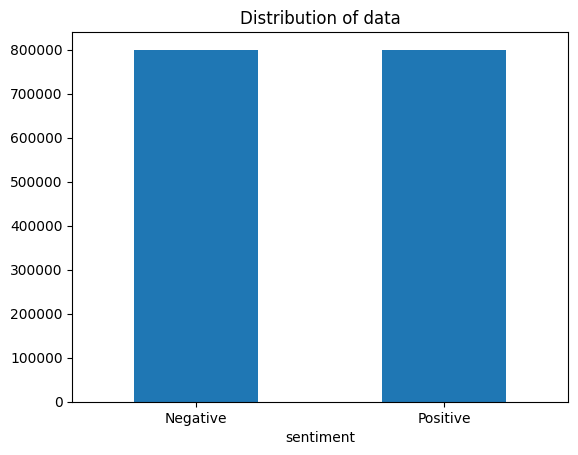

In [7]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [8]:
dataset.head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


Preprocess Text: To Preprocess the text, we defined several regex patterns that would remove user handles, urls, and non alphabetic symbols. As well, the tweets where lower cased. This preprocessing is based on

In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
def preprocess(textdata):
    processedText = []

    ##use regular expressions to process tweets

    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    for tweet in textdata:


        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)

        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        #only keep alphanumeric characters
        tweet = re.sub(alphaPattern, " ", tweet)
        #remove letters that repeat more than twice
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweet = tweet.lower()

        words = tweet.split()
        #lemantize words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]


        processed_tweet = ' '.join(lemmatized_words)



        processedText.append(processed_tweet)

    return processedText

In [10]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import time
t = time.time()
text, sentiment = list(dataset['text']), list(dataset['sentiment'])
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 88 seconds


In [12]:
print(text[100])

 Body Of Missing Northern Calif. Girl Found: Police have found the remains of a missing Northern California girl .. http://tr.im/imji


In [13]:
print(processedtext[100])

body missing northern calif girl found police found remains missing northern california girl url


In [14]:
print(text[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [15]:
print(processedtext[0])

user url aww bummer shoulda got david carr third day


In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Building Dataset

In [17]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = [(label, text) for label, text in enumerate(processedtext)]

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Build the vocabulary based on the training data
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"], max_tokens=
                                  20000)
vocab.set_default_index(vocab["<unk>"])



In [18]:
print(list(vocab.get_stoi().keys())[9000])
word_index = vocab.get_stoi()['lakers']
print(f"Index of 'lakers': {word_index}")
print(len(vocab))

hamster
Index of 'lakers': 900
20000


In [19]:
class CustomDataset(Dataset):

    def __init__(self, data, labels, vocab, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]

        # Convert text to numerical indices using the vocabulary
        numerical_indices = [self.vocab[word] for word in text]
        numerical_indices =torch.as_tensor(numerical_indices, dtype=torch.long)

        # Convert label to one-hot encoding
        one_hot_label = one_hot(torch.as_tensor(label, dtype=torch.long), num_classes=2)

        sample = {'data': numerical_indices, 'label': one_hot_label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [20]:
twitterdataset = CustomDataset(data=processedtext, labels=sentiment, vocab = vocab)

In [21]:
data = twitterdataset.data
labels = twitterdataset.labels


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Further split the test set into validation and test sets
validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

Here I am  pulling a random sentece from the data to verify that it is being stored correctly



In [22]:
print(train_data[10])

home throat killing need cook work clean shower apply internship busy busy


In [23]:
print(train_labels[10])

0


Here we pad the data so it can be used in the data loader

In [24]:
def collate_fn(batch):
    data = [torch.tensor(item['data']) for item in batch]
    label = [item['label'] for item in batch]


    # Pad sequences to the length of the longest sequence in the batch
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)

    # Stack one-hot encoded labels
    label_stacked = torch.stack(label, dim=0)

    return {'data': data_padded, 'label': label_stacked}

In [25]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataset = CustomDataset(train_data, train_labels, vocab)
validation_dataset = CustomDataset(validation_data, validation_labels, vocab)
test_dataset = CustomDataset(test_data, test_labels, vocab)

# Calculate the number of samples to use (20% of the dataset)
trainnum_samples = int(0.2 * len(train_dataset))
valnum_samples = int(0.2 * len(validation_dataset))
testnum_samples = int(0.2 * len(test_dataset))

# Create indices for the subset
trainindices = torch.randperm(len(train_dataset))[:trainnum_samples]
valindices = torch.randperm(len(validation_dataset))[:valnum_samples]
testindices = torch.randperm(len(test_dataset))[:testnum_samples]

# Create a SubsetRandomSampler using the indices
trainsubset_sampler = SubsetRandomSampler(trainindices)
valsubset_sampler = SubsetRandomSampler(valindices)
testsubset_sampler = SubsetRandomSampler(testindices)



# Create DataLoader instances for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=trainsubset_sampler)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=valsubset_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=testsubset_sampler)


In [26]:
num_batches = len(train_loader)

print(f"Number of batches in the DataLoader: {num_batches}")

Number of batches in the DataLoader: 2000


To check that my data loaders are storing correct information, I check a couple samples from the first batch

In [27]:
for batch in validation_loader:
    # Access data and labels from the batch
    data_batch = batch['data']
    label_batch = batch['label']

    # Print a couple of samples from the batch
    for i in range(min(2, len(data_batch))):  # Print at most 2 samples
        print("Sample {}: ".format(i + 1))
        print("Data (Mapped to Integers):", data_batch[i])
        print("Label (One-Hot Encoding):", label_batch[i])

    # Break the loop after the first batch for demonstration purposes
    break

Sample 1: 
Data (Mapped to Integers): tensor([ 736,    0, 5941,  505,  452, 3158,    0,  452,  119,    0, 1389,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])
Label (One-Hot Encoding): tensor([0, 1])
Sample 2: 
Data (Mapped to Integers): tensor([ 505,  452,  736, 6949,    0, 5941,  147,  523,  452, 4193, 6949, 1624,
         222,    0, 1389,  452,  452, 6949, 5941,  147,  623,    0,    0,  505,
        1389, 1624, 4193, 6949, 

<ipython-input-24-fee60e2c4e5e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


## Transformer Model

In [28]:
print(len(vocab))

20000


Now i will build a transformer model

In [29]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, hiddendim, numlayers, num_classes=2, dropout = 0.1, max_len=200):
        super(TransformerClassifier, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        #positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)

        # Transformer layer
        transformer_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=hiddendim, dropout=dropout)
        self.transformer = TransformerEncoder(transformer_layer, num_layers=numlayers)
        # Output layer
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = torch.mean(x, dim=1)

        x = self.fc(x)
        return x

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].detach()
        return self.dropout(x)

In [31]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)



In [32]:
def train_model(num_epochs,learning_rate,trainloader,valloader, num_heads, hiddendim, embeddingdim, numlayers, dropout):
    #model = CustomTransformer(input_size, hidden_dim, num_layers, num_heads, output_dim)
    model = TransformerClassifier(vocab_size=len(vocab), d_model = embeddingdim, nhead=num_heads, hiddendim=hiddendim, numlayers=numlayers, dropout=dropout).to(device)
    print(model)
    model.apply(weights_init)

    t = time.time()


    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5.0, gamma=0.9)
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for batch in trainloader:

          inputs = batch['data'].to(device)
          targets = batch['label'].to(device)
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)
          #outputs = torch.relu(outputs)

          #outputs = torch.sigmoid(outputs)
          #print(outputs)
          targets = targets.type(torch.FloatTensor)
          # Compute the loss
          targets = torch.argmax(targets, dim=1).to(device)
          loss = criterion(outputs, targets)

          #predicted_labels = torch.argmax(outputs, dim=1)
          _, predicted = torch.max(outputs, 1)
          #print(targets)
          # Backward pass and optimization
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

          optimizer.step()

          running_loss += loss.item()

      train_loss = running_loss / len(trainloader)
      train_losses.append(train_loss)


      # Validation
      model.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch in valloader:

              inputs = batch['data'].to(device)
              #print(inputs)
              targets = batch['label'].to(device)
              targets = targets.type(torch.FloatTensor)
              outputs = model(inputs)
              targets = torch.argmax(targets, dim=1).to(device)



              loss = criterion(outputs, targets)
              val_loss += loss.item()



              #_, predicted = torch.max(outputs, 0)
              predicted_labels = torch.argmax(outputs, dim=1)
              #print(predicted_labels)
              # Convert one-hot encoded target to class indices
              #print(predicted_labels)

              true_labels = targets
              #print(true_labels)
              total += len(true_labels)
              # correct += (predicted == labels).sum().item()
              correct += (predicted_labels == true_labels).sum().item()
      val_loss /= len(valloader)
      val_losses.append(val_loss)
      val_accuracy = 100*(correct/total)
      #val_accuracy = 0
      val_accuracies.append(val_accuracy)
      #val_accuracies.append(0)

      # Print the training and validation metrics for the current epoch
      print(f'Epoch [{epoch + 1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Validation Loss: {val_loss:.4f} - '
            f'Scheduler LR: {scheduler.get_lr()[0]} -'
            f'Validation Accuracy: {val_accuracy:.2f}%')
      print(f'Time Taken: {round(time.time()-t)} seconds')
    print('Finished Training')
    losses = (train_losses, val_losses,val_accuracies)
    return (losses, model)

In [33]:
def plot_losses(losses):
    train_losses,val_losses,val_accuracies = losses
    epochs = range(1, len(train_losses) + 1)


    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')


    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='r')


    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Curves')
    plt.legend()


    plt.show()

best model so far

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerClassifier(
  (embedding): Embedding(20000, 40)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=80, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=80, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=40, out_features=2, bias=True)
)


<ipython-input-24-fee60e2c4e5e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1/20] - Train Loss: 0.6811 - Validation Loss: 0.6701 - Scheduler LR: 0.0005 -Validation Accuracy: 59.23%
Time Taken: 79 seconds
Epoch [2/20] - Train Loss: 0.6713 - Validation Loss: 0.6682 - Scheduler LR: 0.0005 -Validation Accuracy: 59.64%
Time Taken: 155 seconds
Epoch [3/20] - Train Loss: 0.6692 - Validation Loss: 0.6661 - Scheduler LR: 0.0005 -Validation Accuracy: 59.80%
Time Taken: 232 seconds
Epoch [4/20] - Train Loss: 0.6677 - Validation Loss: 0.6644 - Scheduler LR: 0.0005 -Validation Accuracy: 59.92%
Time Taken: 309 seconds
Epoch [5/20] - Train Loss: 0.6665 - Validation Loss: 0.6630 - Scheduler LR: 0.0005 -Validation Accuracy: 60.15%
Time Taken: 387 seconds
Epoch [6/20] - Train Loss: 0.6654 - Validation Loss: 0.6654 - Scheduler LR: 0.0005 -Validation Accuracy: 59.98%
Time Taken: 467 seconds
Epoch [7/20] - Train Loss: 0.6646 - Validation Loss: 0.6628 - Scheduler LR: 0.0005 -Validation Accuracy: 60.35%
Time Taken: 544 seconds
Epoch [8/20] - Train Loss: 0.6640 - Validation Lo

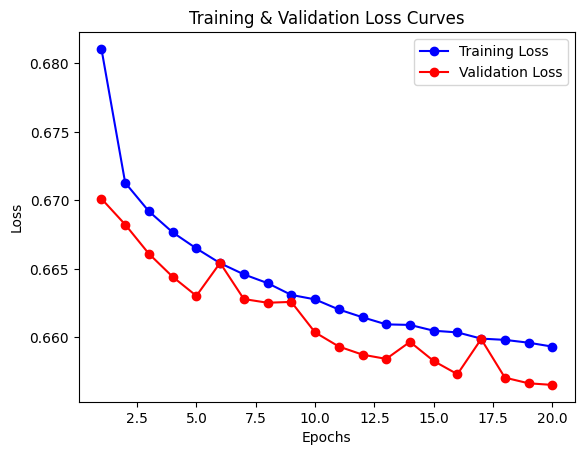

In [34]:
num_epochs = 20
learning_rate = 0.0005
num_heads = 5
hiddendim = 80
numlayers = 2
embeddingdim = 40

losses,finalmodel = train_model(num_epochs,learning_rate,train_loader,train_loader, num_heads, hiddendim, embeddingdim, numlayers, dropout = 0.2)
plot_losses(losses)

This is currently best model getting accuracy of close to 60 percent in around 79 seconds per epoch on gpu

Next I will evaluate the model using our test data

In [35]:
finalmodel.eval()

# Assuming you have a DataLoader for the test dataset, named test_loader
# test_loader = ...

correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():  # Disable gradient computation during inference
    for batch in test_loader:
        # Forward pass
        inputs = batch['data'].to(device)
        targets = batch['label'].to(device)
        targets = targets.type(torch.FloatTensor)
        outputs = finalmodel(inputs)
        targets = torch.argmax(targets, dim=1).to(device)


        # Get predictions
        predicted_labels = torch.argmax(outputs, dim=1)

        # Update counts
        true_labels = targets

        total += len(true_labels)

        correct += (predicted_labels == true_labels).sum().item()



# Compute accuracy
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

<ipython-input-24-fee60e2c4e5e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


Test Accuracy: 61.01%


TransformerClassifier(
  (embedding): Embedding(10000, 512)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


<ipython-input-28-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


Epoch [1/5] - Train Loss: 0.6800 - Validation Loss: 0.6665 - Validation Accuracy: 59.81%
Time Taken: 1657 seconds
Epoch [2/5] - Train Loss: 0.6682 - Validation Loss: 0.6648 - Validation Accuracy: 59.93%
Time Taken: 3309 seconds
Epoch [3/5] - Train Loss: 0.6668 - Validation Loss: 0.6656 - Validation Accuracy: 59.97%
Time Taken: 4956 seconds
Epoch [4/5] - Train Loss: 0.6664 - Validation Loss: 0.6647 - Validation Accuracy: 59.92%
Time Taken: 6597 seconds
Epoch [5/5] - Train Loss: 0.6669 - Validation Loss: 0.6643 - Validation Accuracy: 60.03%
Time Taken: 8235 seconds
Finished Training


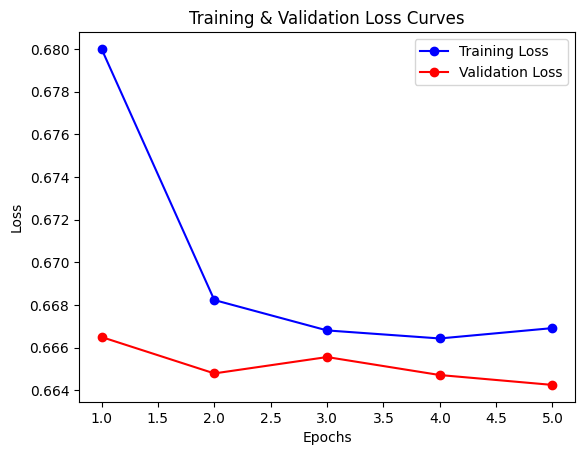

In [ ]:
num_epochs = 5
learning_rate = 0.0001
num_heads = 8
hiddendim = 2048
numlayers = 4
embeddingdim = 512

losses,finalmodel2 = train_model(num_epochs,learning_rate,train_loader,train_loader, num_heads, hiddendim, embeddingdim, numlayers)
plot_losses(losses)

Now I will try create a transformer using a pretrained model and compare it to our custom model.